In [3]:
import os, sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
import pylab

import itertools
from itertools import product
import json

In [4]:
def make_units_with_lyr_for_cstr(expt_id, units_fname, cstr):
    
    #units_fname = os.path.join(units_df_basedir,expt_id + '_units_df.pkl')
    cstr_lyr = pd.DataFrame()
    units_df = pd.read_pickle(units_fname)
    visp_units = units_df[units_df.ecephys_structure_acronym == cstr].index.values#[:5]
    #cstr_lyr['unit_id'] = visp_units
    
    lyrs_dir = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/layer_est_from_Jung/'
    lyr_fname = os.path.join(lyrs_dir,expt_id+'_layer.json')
    try:
        with open(lyr_fname) as datafile:
            data = json.load(datafile)
        lyr_df = pd.DataFrame(data.items(), index = data.keys())
        cstr_lyr = lyr_df.loc[list(units_df[units_df.ecephys_structure_acronym ==cstr].peak_channel_id.values.astype(str))]
        cstr_lyr.columns = ['peak_channel_id','layer']
        cstr_lyr['unit_id'] = visp_units
    except Exception as e:
        print(e)
        cstr_lyr['unit_id'] = visp_units
        cstr_lyr['layer'] = 0.*cstr_lyr.shape[0]
    
    return units_df, cstr_lyr

def make_prs_df_with_lyr_for_given_condition(prs_df_dir, expt_id, cstr):
    tmp = pd.DataFrame()
    for fname in os.listdir(prs_df_dir):
        tmp_pd = pd.read_pickle(os.path.join(prs_df_dir,fname))
        tmp = pd.concat((tmp,tmp_pd), sort=False)
    
    tmp.index = tmp['unit_id'].values
    return tmp

In [5]:
def make_heatmap_of_pc_with_src_cstr(tmp1_df, src_cstr):
    xv = np.where(np.diff(tmp1_df.layer.values))[0]+0.5
    yv = np.where(np.diff(tmp1_df.layer.values))[0]+0.5
    src_units = tmp1_df.unit_id.values #units_df[units_df.ecephys_structure_acronym==src_cstr].index.values #
    if len(src_units)>0:
        cpl_matrix = tmp1_df[src_units].values.astype(float)
        max_cpl = np.amax(np.abs(cpl_matrix))
        fig,ax = plt.subplots(1,1, figsize = (15,10))
        plt.imshow(cpl_matrix, aspect='auto', cmap = 'bwr', vmin = -max_cpl, vmax = max_cpl)
        ax.set_yticks(range(cpl_matrix.shape[0]))
        ax.set_yticklabels(tmp1_df.layer.values,fontsize=10,rotation=0)
        ax.set_xticks(range(cpl_matrix.shape[0]))
        ax.set_xticklabels(tmp1_df.layer.values,fontsize=10,rotation=0)
        ax.vlines(xv, 0, 1, transform=ax.get_xaxis_transform(), color='k')
        ax.hlines(yv, 0, 1, transform=ax.get_yaxis_transform(), color='k')
        plt.colorbar()
        plt.show()

def make_test_corr_box_plot(tmp1_df, fig_title, fig_savename = None):
    
    max_test_corr_vals_2 = tmp1_df.test_corr.fillna(0).values

    fig = pylab.figure(figsize = (12,8))

    boxprops = dict(linestyle='-', linewidth=3, color='b')
    medianprops = dict(linestyle='-', linewidth=3, color='b')
    whiskerprops = dict(linestyle='-',linewidth=3, color='b')

    df=pd.DataFrame(np.array(max_test_corr_vals_2))
    box_plot=df.boxplot(boxprops=boxprops, whiskerprops = whiskerprops, medianprops = medianprops)

    x=1.9+0.2*np.random.rand(len(max_test_corr_vals_2))
    pylab.scatter(x,max_test_corr_vals_2,s=30)
    pylab.yticks(fontsize=30)
    print (box_plot)

    pylab.title(fig_title, fontsize = 30)#(expt_id+ '_' + cstr, fontsize = 30)
    if fig_savename is not None:
        pylab.savefig(fig_savename)
        
    pylab.show()

In [6]:
def get_num_units_in_cstr(units_df):
    
    cstr_list = sorted(units_df.ecephys_structure_acronym.unique())
    num_units_in_cstr = pd.DataFrame(index = range(1), columns = cstr_list)
    for cstr_name in cstr_list:
        num_units = np.shape(units_df[units_df.ecephys_structure_acronym == cstr_name])[0]
        num_units_in_cstr[cstr_name] = num_units
    
    cstr_to_drop = [cc for cc in num_units_in_cstr.columns.values if num_units_in_cstr[cc].values < 2.]

    return num_units_in_cstr, cstr_to_drop

def make_nnz_cpl_df(units_df, visp_units, tmp1):
    
    cstr_list = sorted(units_df.ecephys_structure_acronym.unique())
    nnz_cpl_from_cstr_counts = pd.DataFrame(index = visp_units, columns = cstr_list + ['total_nnz','stim','layer'])
    regr_cols = [ii for ii in tmp1.columns if (isinstance(ii,int) or isinstance(ii,np.int64))]

    for ii, uid in enumerate(tmp1.unit_id.values):
        #nnz_cpl_from_cstr_counts.loc[uid]['total_nnz'] = tmp1.iloc[np.where(tmp1.unit_id == uid)[0], 11:].fillna(0).astype(bool).sum(axis=1).values[0]
        nnz_cpl_from_cstr_counts.loc[uid]['total_nnz'] = tmp1.iloc[np.where(tmp1.unit_id == uid)[0]][regr_cols].fillna(0).astype(bool).sum(axis=1).values[0]
        #tmp_nnz_vals_df = tmp1.iloc[np.where(tmp1.unit_id == uid)[0],8:].fillna(0).astype(bool)
        tmp_nnz_vals_df = tmp1.iloc[np.where(tmp1.unit_id == uid)[0]][regr_cols].fillna(0).astype(bool)
        cols = tmp_nnz_vals_df.columns
        for cstr_area in cstr_list:
            nnz_cols_all = cols[np.where(tmp_nnz_vals_df.iloc[0,:])]
            nnz_cols_cstr = nnz_cols_all[nnz_cols_all>120]
            nnz_counts = len(np.where(units_df.loc[nnz_cols_cstr].ecephys_structure_acronym==cstr_area)[0])
            nnz_cpl_from_cstr_counts.loc[uid][cstr_area] = nnz_counts
            nnz_cpl_from_cstr_counts.loc[uid]['layer'] = tmp1.iloc[np.where(tmp1.unit_id == uid)[0]]['layer'].values[0]

    nnz_cpl_from_cstr_counts['stim'] = nnz_cpl_from_cstr_counts['total_nnz'] - nnz_cpl_from_cstr_counts.iloc[:,:-3].sum(axis=1)
    nnz_cpl_from_cstr_counts = nnz_cpl_from_cstr_counts.dropna()
    #nnz_cpl_from_cstr_counts['layer'] = tmp1[nnz_cpl_from_cstr_counts.index.isin(tmp1.unit_id.values)]['layer'].values

    return nnz_cpl_from_cstr_counts


def make_stim_nnz_cpl_df_and_plot(tmp1_df, fig_savename = None):
    
    #xv = np.arange(20,120,20)-0.5
    yv = np.where(np.diff(tmp1_df.layer.values))[0]+0.5

    stim_cpl_df = tmp1_df[range(120)]
    stim_cpl_df_nnz = stim_cpl_df.loc[:, (stim_cpl_df != 0).any(axis=0)]
    xv = np.where(np.mod(1.+stim_cpl_df_nnz.columns.values.astype(float),20)==0.)[0]+0.5
    
    stim_cpl_matrix = stim_cpl_df_nnz.values.astype(float)
    max_cpl = np.amax(np.abs(stim_cpl_matrix))
    fig,ax = plt.subplots(1,1, figsize = (15,10))
    plt.imshow(stim_cpl_matrix, aspect='auto', cmap = 'bwr', vmin = -max_cpl, vmax = max_cpl)
    ax.set_yticks(range(stim_cpl_matrix.shape[0]))
    ax.set_yticklabels(tmp1_df.layer.values,fontsize=10,rotation=0)
    ax.set_xticks(range(stim_cpl_matrix.shape[1]))
    ax.set_xticklabels(stim_cpl_df_nnz.columns.values,fontsize=10,rotation=45)
    ax.vlines(xv, 0, 1, transform=ax.get_xaxis_transform(), color='g')
    ax.hlines(yv, 0, 1, transform=ax.get_yaxis_transform(), color='k')
    
    plt.colorbar()
    plt.tight_layout()
    if fig_savename is not None:
        plt.savefig(fig_savename)
    plt.show()

In [7]:
np.arange(20,120,20)

array([ 20,  40,  60,  80, 100])

In [8]:
def normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts, units_df, visp_units, \
                                  tmp1_df, cols_to_keep = None, fig_savename=None):
    
    yv = np.where(np.diff(tmp1_df.layer.values))[0]+0.5
    
    cstr_list = sorted(units_df.ecephys_structure_acronym.unique())
    num_units_in_cstr_df, cstr_to_drop = get_num_units_in_cstr(units_df)
    norm_nnz_df = nnz_cpl_from_cstr_counts.iloc[:,:-3]/np.squeeze(num_units_in_cstr_df.values)
    norm_nnz_df = norm_nnz_df.drop(cstr_to_drop,axis=1)
    cstr_list.remove(cstr_to_drop[0])
    
    if cols_to_keep is not None:
        norm_nnz_df = norm_nnz_df[cols_to_keep]
        cstr_list = cols_to_keep
    
    norm_nnz = norm_nnz_df.values.astype(float)

    fig,ax = plt.subplots(1,1,figsize = (15,10))
    #im = plt.imshow(norm_nnz, aspect='auto',vmin=0,vmax = 1.0*np.amax(norm_nnz))
    im = plt.imshow(norm_nnz, aspect='auto',vmin= 0.0, vmax = 1.0, cmap = 'magma')
    ax.set_xticks(range(len(cstr_list)))
    ax.set_xticklabels(cstr_list,fontsize=30,rotation=45)
    ax.set_yticks(range(norm_nnz.shape[0]))
    ax.set_yticklabels(tmp1_df.layer.values,fontsize=10,rotation=0)
    plt.hlines(yv, -1.,len(cstr_list)-1, transform=ax.get_yaxis_transform(), color='g')

    cbar = fig.colorbar(im, shrink=0.99, aspect=20, fraction=.12,pad=.02)
    cbar.ax.tick_params(labelsize=30)

    fig_str = expt_id+ '_' + cstr + '_nnz_cpl'
    plt.title(fig_str, fontsize = 30)
    plt.tight_layout()
    if fig_savename is not None:
        plt.savefig(fig_savename)
        
    plt.show()
    

In [14]:
units_df_basedir = '/Users/Ram/Dropbox/VC_NP_sklearn_copy/units_dfs'

expt_id_list = ['715093703']#['719161530']#['715093703'] #,'719161530'
split_frac = 0.5

stim_name = 'static_gratings'
bin_dt = 0.005
bin_start = 0.05 #0.05#0.05
bin_end = 0.15 #0.15#0.15

#vis_cols = ['VISp']#['LGd','LP','VISam','VISpm','VISp','VISl','VISrl']
cstr = 'VISp'

basedir = '/Users/Ram/Dropbox/VC_NP_sklearn_mod/sandbox_save_prs'

for expt_id in expt_id_list:

    units_fname = os.path.join(units_df_basedir,expt_id + '_units_df.pkl')
    units_df, cstr_lyr_df = make_units_with_lyr_for_cstr(expt_id, units_fname, cstr)
    
    prs_df_dir =  os.path.join(basedir, expt_id, cstr, \
           stim_name, 't1_'+str(bin_start) + '_t2_'+str(bin_end) + '_dt_'+str(bin_dt), 'max_test_corr')
        
    prs_df_with_lyr = make_prs_df_with_lyr_for_given_condition(prs_df_dir, expt_id, cstr)
    
    tmp = pd.merge(cstr_lyr_df, prs_df_with_lyr, on=['unit_id'])
    tmp1 = tmp.sort_values('layer')

In [15]:
type(tmp1.columns[15])

numpy.int64

In [16]:
#(list(tmp1.columns[-1037:]))
regr_cols = [ii for ii in tmp1.columns if (isinstance(ii,int) or isinstance(ii,np.int64))]
len(regr_cols)
tmp1[regr_cols].head()

,950910319,950910352,950910364,950910371,950910392,950910435,950910427,950910463,950910531,950910576,...,110,111,112,113,114,115,116,117,118,119
61,-0,-0,-0,0.000484709,-0,0.00046326,0,-0,0,9.64542e-05,...,-0,0,0,0,-0,0,0,0,0,0
57,0,-0,4.39656e-05,-0,-0.00071165,-0.00274846,0.000239302,-0,-0,-0,...,-0,0,-0,-0,-0,-6.61436e-05,-0,-0,7.64031e-07,0
60,0,0,0,-0,0.000457869,-0.000177782,0,0.00119991,0,-0,...,2.09805e-05,-9.73487e-06,2.84047e-06,0,0,2.5541e-11,-0,0,0,-0
59,-0,0.00449763,0,-0,0,0.00264946,0,-0.00292808,-0.0036403,-0,...,0,1.04801e-05,-0,5.82391e-08,0,0,3.39409e-05,-0,-2.40021e-06,0
58,0,-0,-0,-0,0,0,0,0,-1.02145e-06,-0,...,-0,-0,-3.14157e-07,0,-3.01056e-07,-7.45959e-08,-4.8754e-05,7.92694e-08,0.000100278,-4.436e-05


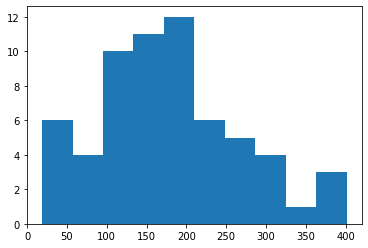

In [17]:
plt.figure()
plt.hist(tmp1.nnz_coef.values)
plt.show()

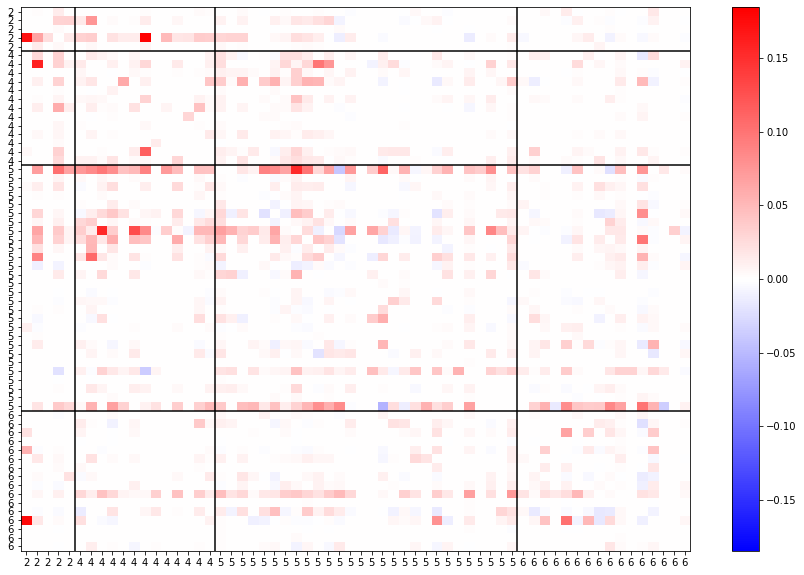

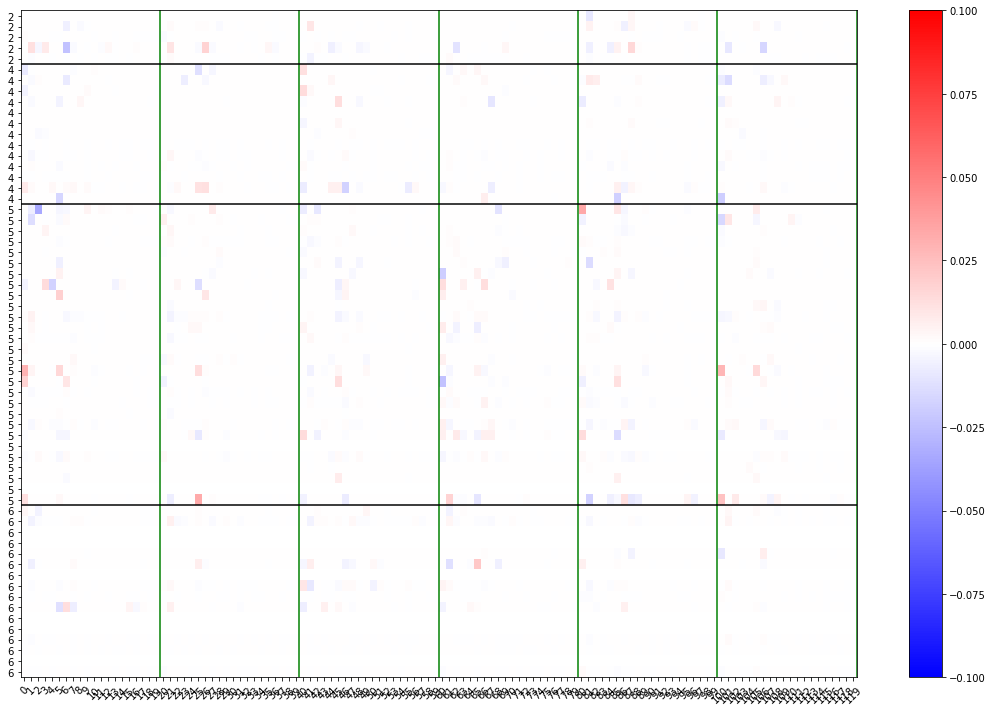

AxesSubplot(0.125,0.125;0.775x0.755)


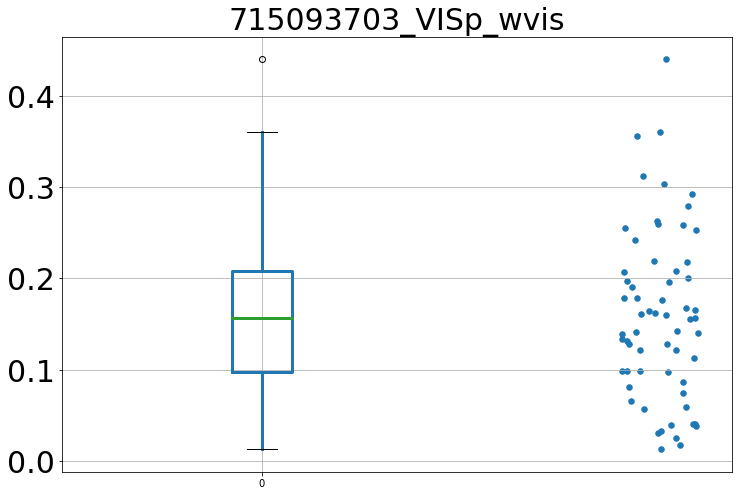

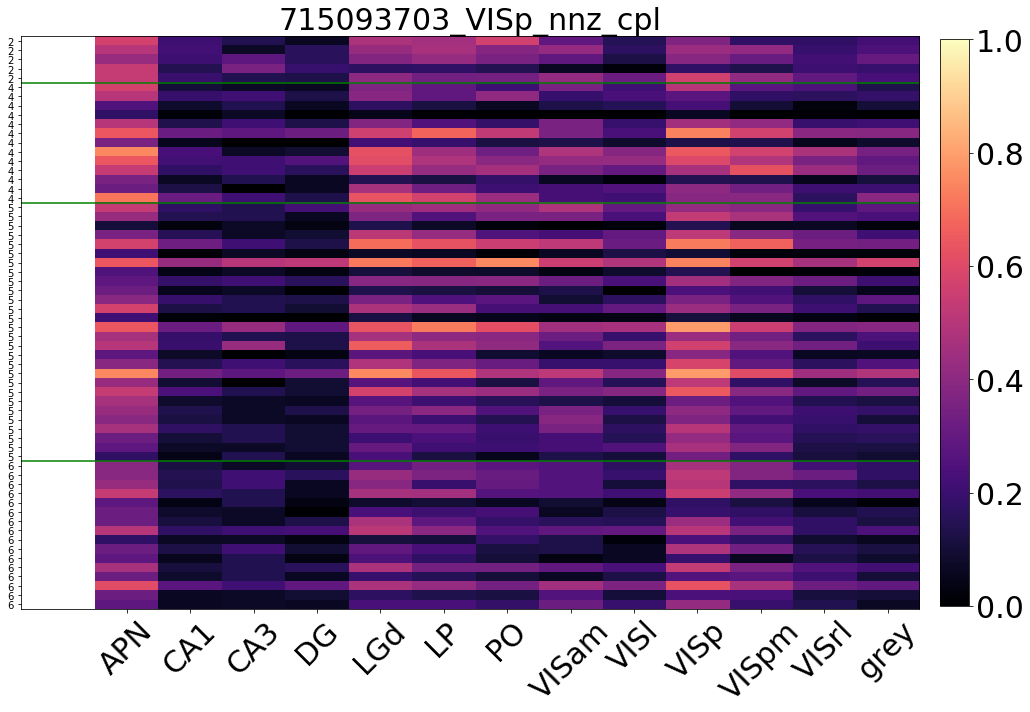

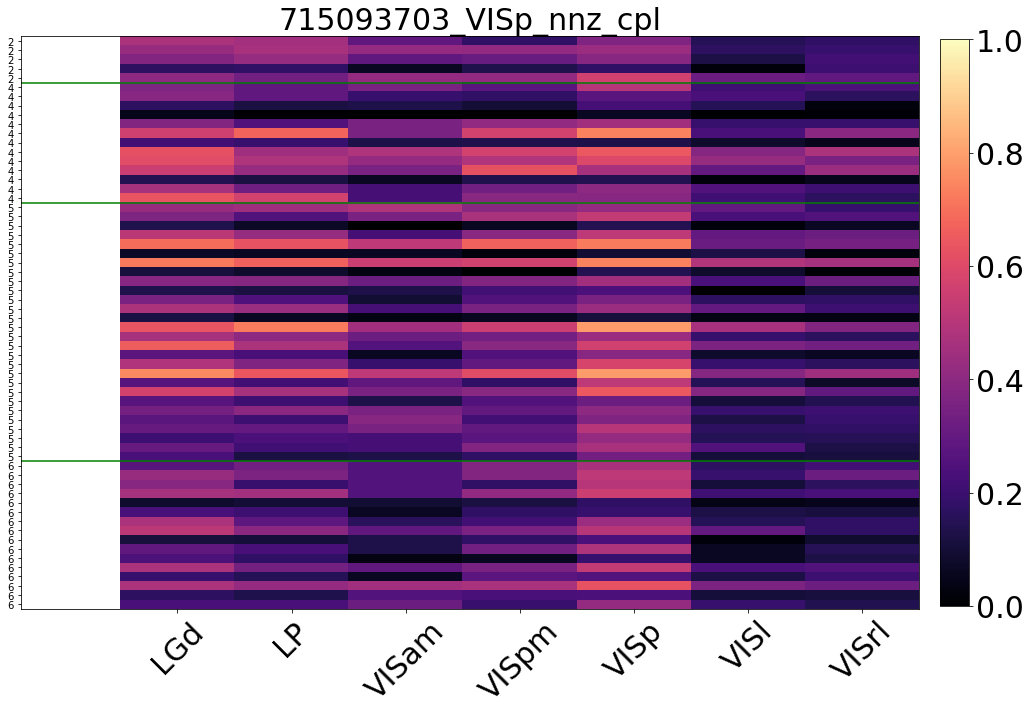

In [18]:
# #figs_savedir = os.path.join(basedir, expt_id, 'dt_',str(dt),'Figures')
# figs_savedir = os.path.join(basedir, expt_id, 'dt_' + str(dt),'Figures')
# if not os.path.exists(figs_savedir):
#     os.makedirs(figs_savedir)

make_heatmap_of_pc_with_src_cstr(tmp1, cstr)

#fig_stim_nnz = os.path.join(figs_savedir, cstr + '_stim_cpl.png')
make_stim_nnz_cpl_df_and_plot(tmp1,fig_savename = None)#fig_stim_nnz)

#print(ram)

fig_title = expt_id + '_' + cstr + '_wvis'
#fig_summary = os.path.join(figs_savedir, cstr + '_wvis_summary.png')
make_test_corr_box_plot(tmp1, fig_title, fig_savename = None)#fig_summary)

# fig_cstr_nnz = os.path.join(figs_savedir, cstr + '_wvis_nnz_cpl.png')
                            
visp_units = units_df[units_df.ecephys_structure_acronym == cstr].index.values
nnz_cpl_from_cstr_counts = make_nnz_cpl_df(units_df, visp_units, tmp1)
                            
normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts,units_df,visp_units,tmp1,\
                               cols_to_keep = None,fig_savename = None)#fig_cstr_nnz)

#fig_cstr_only_vis_nnz = os.path.join(figs_savedir, cstr + '_wvis_only_vis_nnz_cpl.png')
vis_cols = ['LGd','LP','VISam','VISpm','VISp','VISl','VISrl']
normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts,units_df,visp_units,tmp1,\
                               cols_to_keep=vis_cols,fig_savename = None)#fig_cstr_only_vis_nnz)

In [73]:
nnz_cpl_from_cstr_counts = make_nnz_cpl_df(units_df, visp_units, tmp1)

nnz_cpl_from_cstr_counts[nnz_cpl_from_cstr_counts.layer==4]

,APN,CA1,CA3,DG,LGd,LP,PO,PoT,VISam,VISl,VISp,VISpm,VISrl,grey,total_nnz,stim,layer
950931770,8,14,2,2,12,20,9,0,5,6,22,5,7,12,142,18,4
950931751,11,9,3,4,19,31,8,0,4,5,20,12,13,21,231,71,4
950931727,8,21,2,2,23,44,21,0,8,6,21,12,9,21,202,4,4
950931853,16,25,4,3,23,43,23,0,7,9,32,17,16,24,332,90,4
950931959,8,3,0,0,10,12,6,1,3,3,11,4,6,6,91,18,4
950931899,14,26,3,4,30,55,25,0,7,9,28,15,15,28,307,48,4
950931878,8,13,2,3,6,11,10,0,3,4,13,4,5,11,109,16,4
950933890,7,12,2,1,24,38,19,1,2,2,16,8,8,12,258,106,4
950932102,6,19,2,3,16,25,11,0,2,5,27,11,14,22,257,94,4
950932087,15,38,2,5,39,49,27,0,6,7,25,18,11,29,335,64,4


In [74]:
tmp1[tmp1.layer==4][['unit_id','nnz_coef','layer','']]

,unit_id,nnz_coef,layer
46,950931727,157,4
47,950931853,202,4
48,950931959,71,4
49,950931899,247,4
50,950931878,84,4
44,950931770,119,4
52,950932102,155,4
51,950933890,188,4
56,950933924,123,4
45,950931751,157,4


In [77]:
units_df.columns

Index(['amplitude_cutoff', 'max_drift', 'd_prime', 'waveform_halfwidth',
       'waveform_velocity_above', 'cluster_id', 'local_index_unit',
       'nn_miss_rate', 'silhouette_score', 'isolation_distance',
       'peak_channel_id', 'isi_violations', 'waveform_PT_ratio', 'nn_hit_rate',
       'cumulative_drift', 'L_ratio', 'waveform_amplitude',
       'waveform_repolarization_slope', 'waveform_recovery_slope',
       'presence_ratio', 'waveform_spread', 'firing_rate', 'waveform_duration',
       'waveform_velocity_below', 'snr', 'probe_vertical_position', 'probe_id',
       'probe_horizontal_position', 'ecephys_structure_acronym',
       'channel_local_index', 'ecephys_structure_id', 'probe_description',
       'location', 'probe_sampling_rate', 'probe_lfp_sampling_rate',
       'probe_has_lfp_data'],
      dtype='object')

In [27]:
# visp_units = units_df[units_df.ecephys_structure_acronym == cstr].index.values
# nnz_cpl_from_cstr_counts = make_nnz_cpl_df(units_df, visp_units, tmp1)
# num_units_in_cstr_df, cstr_to_drop = get_num_units_in_cstr(units_df)
# normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts,units_df,visp_units,tmp1,cols_to_keep = None,fig_savename=None)

In [28]:
# vis_cols = ['LGd','LP','VISam','VISpm','VISp','VISl','VISrl']
# normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts,units_df,visp_units,tmp1,cols_to_keep=vis_cols,fig_savename=None)

In [29]:
#tmp1.head()

In [30]:
#visp_units = units_df[units_df.ecephys_structure_acronym == cstr].index.values
#nnz_cpl_from_cstr_counts = make_nnz_cpl_df(units_df, visp_units, tmp1)
#nnz_cpl_from_cstr_counts.head()

In [31]:
#num_units_in_cstr_df, cstr_to_drop = get_num_units_in_cstr(units_df)
#num_units_in_cstr_df
#
#normalize_and_plot_nnz_cpl_df(nnz_cpl_from_cstr_counts, units_df, visp_units, tmp1, fig_savename=None)

In [32]:
# norm_nnz_df = nnz_cpl_from_cstr_counts.iloc[:,:-3]/np.squeeze(num_units_in_cstr_df.values)
# norm_nnz_df = norm_nnz_df.drop(cstr_to_drop,axis=1)
# norm_nnz = norm_nnz_df.values.astype(float)

# fig,ax = plt.subplots(1,1,figsize = (15,10))
# im = plt.imshow(norm_nnz, aspect='auto',vmin=0,vmax = 1.0*np.amax(norm_nnz))
# ax.set_xticks(range(len(cstr_list)))
# ax.set_xticklabels(cstr_list,fontsize=30,rotation=45)
# ax.set_yticks(range(norm_nnz.shape[0]))
# ax.set_yticklabels(tmp1.layer.values,fontsize=10,rotation=0)
# cbar = fig.colorbar(im, shrink=0.99, aspect=20, fraction=.12,pad=.02)
# cbar.ax.tick_params(labelsize=30)

# savename = os.path.join(basedir, expt_id+ '_nnz_cpl_normalized_plots')
# if not os.path.exists(savename):
#     os.makedirs(savename)

# fig_str = expt_id+ '_' + cstr + '_nnz_cpl'
# plt.title(fig_str, fontsize = 30)
# plt.tight_layout()

# #plt.savefig(os.path.join(savename,fig_str))
# plt.show()

In [33]:
# unit_info_dict = {}
# max_test_corr_vals = []
# for cnum, uid in enumerate(visp_units):
#     unit_info_dict[uid] = {}
    
#     if uid in tmp1.unit_id.values:
#         test_corr_vals = tmp1.test_corr[tmp1.unit_id == uid].fillna(0).values
#         nnz_vals = tmp1.iloc[np.where(tmp1.unit_id == uid)[0],8:].fillna(0).astype(bool).sum(axis=1).values
#         alpha_vals = tmp1.alpha_val[tmp1.unit_id == uid].values

#         tmp1_for_unit = tmp1.iloc[np.where(tmp1.unit_id == uid)[0][0],:]
#         max_test_corr = tmp1_for_unit.test_corr

#         max_test_corr_vals.append(max_test_corr)

#         tmp_nnz_vals_df = tmp1.iloc[np.where(tmp1.unit_id == uid)[0],8:].fillna(0).astype(bool)
#         cols = tmp_nnz_vals_df.columns

#         nnz_cols = cols[np.where(tmp_nnz_vals_df.iloc[0,:])]#.astype(int)
#         unit_info_dict[uid]['nnz_cols'] = nnz_cols
#         unit_info_dict[uid]['max_corr_pc'] = tmp1_for_unit

In [34]:
# len(nnz_cols[nnz_cols>120]), len(nnz_cols)

In [35]:
# cstr_list = sorted(units_df.ecephys_structure_acronym.unique())
# nnz_cpl_from_cstr_counts = pd.DataFrame(index = visp_units, columns = cstr_list + ['total_nnz'])

# for cnum, uid in enumerate(tmp1.unit_id.values):
#     nnz_cpl_from_cstr_counts.loc[uid]['total_nnz'] = len(unit_info_dict[uid]['nnz_cols'])
#     for cstr_area in cstr_list:
#         nnz_cols_all = unit_info_dict[uid]['nnz_cols'].values
#         nnz_cols_cstr = nnz_cols_all[nnz_cols_all>120]
#         nnz_counts = len(np.where(units_df.loc[nnz_cols_cstr].ecephys_structure_acronym==cstr_area)[0])
#         #print(cstr_area, nnz_counts)
#         nnz_cpl_from_cstr_counts.loc[uid][cstr_area] = nnz_counts  

# nnz_cpl_from_cstr_counts['stim'] = nnz_cpl_from_cstr_counts['total_nnz'] - nnz_cpl_from_cstr_counts.iloc[:,:-1].sum(axis=1)
# nnz_cpl_from_cstr_counts = nnz_cpl_from_cstr_counts.dropna()

In [36]:
#nnz_cpl_from_cstr_counts

In [37]:
# nnz_cpl_from_cstr_counts['layer'] = tmp1[nnz_cpl_from_cstr_counts.index.isin(tmp1.unit_id.values)]['layer'].values
# # #nnz_cpl_from_cstr_counts
# # #nnz_cpl_from_cstr_counts.index.isin(tmp1.unit_id.values)
# # tmp1[nnz_cpl_from_cstr_counts.index.isin(tmp1.unit_id.values)]['layer'].values
# nnz_cpl_from_cstr_counts

In [38]:
# #norm_nnz = (nnz_cpl_from_cstr_counts.iloc[:,:-1].values.astype(float))/(np.array(num_units_in_cstr))
# cstr_list = sorted(units_df.ecephys_structure_acronym.unique())

# nnz_cpl_df_corr = nnz_cpl_from_cstr_counts.copy()#[nnz_cpl_from_cstr_counts.total_nnz<1000.]
# nnz_cpl_df_corr = nnz_cpl_df_corr.drop('PoT',axis=1)
# cstr_list.remove('PoT')

# num_units_in_cstr = get_num_units_in_cstr(nnz_cpl_df_corr.columns.values[:-3], units_df)
# norm_nnz = (nnz_cpl_df_corr[nnz_cpl_df_corr.columns.values[:-3]].values.astype(float))/(np.array(num_units_in_cstr))


# fig,ax = plt.subplots(1,1,figsize = (15,10))
# im = plt.imshow(norm_nnz, aspect='auto',vmin=0,vmax = 1.0*np.amax(norm_nnz))
# ax.set_xticks(range(len(cstr_list)))
# ax.set_xticklabels(cstr_list,fontsize=30,rotation=45)
# ax.set_yticks(range(norm_nnz.shape[0]))
# ax.set_yticklabels(tmp1.layer.values,fontsize=10,rotation=0)
# cbar = fig.colorbar(im, shrink=0.99, aspect=20, fraction=.12,pad=.02)
# cbar.ax.tick_params(labelsize=30)

# savename = os.path.join(basedir, expt_id+ '_nnz_cpl_normalized_plots')
# if not os.path.exists(savename):
#     os.makedirs(savename)

# fig_str = expt_id+ '_' + cstr + '_nnz_cpl'
# plt.title(fig_str, fontsize = 30)
# plt.tight_layout()

# #plt.savefig(os.path.join(savename,fig_str))
# plt.show()

In [39]:
# cstr_list = sorted(units_df.ecephys_structure_acronym.unique())

# nnz_cpl_df_corr = nnz_cpl_from_cstr_counts.copy()#[nnz_cpl_from_cstr_counts.total_nnz<1000.]
# nnz_cpl_df_corr = nnz_cpl_df_corr.drop('PoT',axis=1)
# cstr_list.remove('PoT')

# vis_cols = ['LGd','LP','VISam','VISpm','VISp','VISl','VISrl']
# num_units_in_cstr = get_num_units_in_cstr(vis_cols, units_df)
# norm_nnz_vis = (nnz_cpl_df_corr[vis_cols].values.astype(float))/(np.array(num_units_in_cstr))

# fig,ax = plt.subplots(1,1,figsize = (15,10))
# im = plt.imshow(norm_nnz_vis, aspect='auto',vmin=0.0*np.amax(norm_nnz_vis),vmax = 1.0*np.amax(norm_nnz_vis))
# ax.set_xticks(range(len(vis_cols)))
# ax.set_xticklabels(vis_cols,fontsize=30,rotation=45)
# ax.set_yticks(range(norm_nnz.shape[0]))
# ax.set_yticklabels(tmp1.layer.values,fontsize=10,rotation=0)
# cbar = fig.colorbar(im, shrink=0.99, aspect=20, fraction=.12,pad=.02)
# cbar.ax.tick_params(labelsize=30)

# savename = os.path.join(basedir, expt_id+ '_vis_only_nnz_cpl_normalized_plots')
# if not os.path.exists(savename):
#     os.makedirs(savename)

# fig_str = expt_id+ '_' + cstr + '_vis_only__nnz_cpl'
# plt.title(fig_str, fontsize = 30)
# plt.tight_layout()

# #plt.savefig(os.path.join(savename,fig_str))
# plt.show()

In [40]:
# for cnum in range(len(visp_units)):
#     #print(visp_units[cnum])
#     test_corr_vals = tmp1.test_corr[tmp1.unit_id == visp_units[cnum]].fillna(0).values
#     nnz_vals = tmp1.iloc[np.where(tmp1.unit_id == visp_units[cnum])[0],:-4].fillna(0).astype(bool).sum(axis=1).values
#     alpha_vals = tmp1.alpha_val[tmp1.unit_id == visp_units[cnum]].values

#     fig,ax = plt.subplots(2,1,figsize = (25,15),sharex=True)
#     ax[0].plot(np.sort(alpha_vals), test_corr_vals[np.argsort(alpha_vals)],'o-',markersize = 15,linewidth = 6)
#     ax[0].set_title('test_corr', fontsize = 30)
#     ax[1].plot(np.sort(alpha_vals), nnz_vals[np.argsort(alpha_vals)],'o-',markersize = 15,linewidth = 6)
#     ax[1].set_ylim([0,10+nnz_vals[np.argsort(alpha_vals)][1]])
#     ax[1].set_title('No. of non-zero coefficients', fontsize = 30)
#     ax[1].set_xlabel('alpha', fontsize = 30)

#     for ii, axi in enumerate(ax):
#         axi.tick_params(axis='both', labelsize=30)

#     fig_str = cstr + '_' + str(visp_units[cnum])
#     savename = os.path.join(basedir, expt_id+ '_' + cstr+'_all_to_all_corr_plots')
#     if not os.path.exists(savename):
#         os.makedirs(savename)

#     plt.suptitle(fig_str, fontsize = 30)
#     plt.savefig(os.path.join(savename,fig_str))
#     plt.close()

In [41]:
# visp_df = units_df[units_df.ecephys_structure_acronym=='VISp']
# visp_df[['peak_channel_id','channel_local_index','ecephys_structure_acronym','probe_vertical_position']]

In [42]:
#visp_df.peak_channel_id.values